In [128]:
try:
    from flaml import AutoML
except ModuleNotFoundError:
    !pip install flaml

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score

In [129]:
try:
    data = pd.read_csv("data/processed_data.csv")

except FileNotFoundError:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

feature_names = X.columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 569
Validation Dataset Samples: 143
Testing Dataset Samples: 179


## Simple initial auto ML training

In [130]:
automl = AutoML()
automl.fit(X_train, y_train, task="classification", time_budget=60, seed=42)

[flaml.automl.logger: 07-22 14:31:51] {1680} INFO - task = classification
[flaml.automl.logger: 07-22 14:31:51] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-22 14:31:51] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-22 14:31:51] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-22 14:31:51] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-22 14:31:51] {2345} INFO - Estimated sufficient time budget=468s. Estimated necessary time budget=11s.
[flaml.automl.logger: 07-22 14:31:51] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.1860,	best estimator lgbm's best error=0.1860
[flaml.automl.logger: 07-22 14:31:51] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-22 14:31:51] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1614,	best estimator lgbm's best error=0.1614
[flaml.automl.logger: 07

We can run this line to see what model it selected.

In [131]:
automl.model

Now let's evaluate this model and put the results into a dataframe.

In [132]:
y_pred_train = automl.predict(X_train)
y_pred_val = automl.predict(X_validate)

tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

results_df = pd.DataFrame({
          'Accuracy (training)': np.mean(y_pred_train == y_train),
          'Accuracy (validation)': np.mean(y_pred_val == y_validate),
          'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
          'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
          "AUC": roc_auc_score(y_validate, y_pred_val),
          "f1": f1_score(y_validate, y_pred_val, average='macro'),
          "FP": fp,
          "FN": fn

          }, index=["Auto ML - Default Parameters - Scoring on ROC AUC"]
).round(3)

results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.858,0.811,0.803,0.797,0.797,0.8,12,15


This seems like pretty reasonable performance, based on our previous interactions with the titanic dataset, though not as good as we've seen sometimes.

## Customisation

Let's define a function that will allow us to quickly calculate and store metrics when assessing the `automl` library.

In [133]:
def auto_ml_get_results(name):
    y_pred_train = automl.predict(X_train)
    y_pred_val = automl.predict(X_validate)

    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

    return pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "FP": fp,
            "FN": fn

            }, index=[name]
    ).round(3)


Now let's 

In [134]:
automl = AutoML()
automl.fit(X_train, y_train, task="classification", time_budget=60,
           metric="f1", seed=42)
results_df = pd.concat(
    [results_df,
    auto_ml_get_results(name="Auto ML - Scoring on f1")]
)

[flaml.automl.logger: 07-22 14:32:51] {1680} INFO - task = classification
[flaml.automl.logger: 07-22 14:32:51] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-22 14:32:51] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 07-22 14:32:51] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-22 14:32:51] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-22 14:32:52] {2345} INFO - Estimated sufficient time budget=4421s. Estimated necessary time budget=109s.
[flaml.automl.logger: 07-22 14:32:52] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.4095,	best estimator lgbm's best error=0.4095
[flaml.automl.logger: 07-22 14:32:52] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-22 14:32:52] {2392} INFO -  at 0.7s,	estimator lgbm's best error=0.4095,	best estimator lgbm's best error=0.4095
[flaml.automl.logger: 07-22

In [135]:
automl = AutoML()
automl.fit(X_train, y_train, task="classification", time_budget=180, seed=42)
results_df = pd.concat(
    [results_df,
    auto_ml_get_results(name="Auto ML - Training for 3 minutes")]
)

[flaml.automl.logger: 07-22 14:33:51] {1680} INFO - task = classification
[flaml.automl.logger: 07-22 14:33:51] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-22 14:33:51] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-22 14:33:51] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-22 14:33:51] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-22 14:33:52] {2345} INFO - Estimated sufficient time budget=4341s. Estimated necessary time budget=107s.
[flaml.automl.logger: 07-22 14:33:52] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.1860,	best estimator lgbm's best error=0.1860
[flaml.automl.logger: 07-22 14:33:52] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-22 14:33:52] {2392} INFO -  at 0.6s,	estimator lgbm's best error=0.1614,	best estimator lgbm's best error=0.1614
[flaml.automl.logger: 

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [136]:
results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.858,0.811,0.803,0.797,0.797,0.800,12,15
Auto ML - Scoring on f1,0.851,0.804,0.795,0.795,0.795,0.795,14,14
Auto ML - Training for 3 minutes,0.863,0.811,0.802,0.800,0.800,0.801,13,14


## Compare this with some other ML models

In [137]:
def fit_train(name="XGBoost", X_train=X_train, X_validate=X_validate,
              y_train=y_train, y_validate=y_validate,
              model=XGBClassifier(random_state=42)
              ):

     model.fit(X_train, y_train)

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)

     tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

     return pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "FP": fp,
            "FN": fn
          }, index=[name]
).round(3)

In [138]:
results_df = pd.concat(
    [results_df,
     fit_train(),
     fit_train(name="Decision Tree (Defaults)", model=DecisionTreeClassifier()),
     fit_train(name="Random Forest (Defaults)", model=RandomForestClassifier(random_state=42)),
     fit_train(name="LightGBM (Defaults)", model=LGBMClassifier(random_state=42)),
     fit_train(name="Catboost (Defaults)", model=CatBoostClassifier(random_state=42, verbose=False)),

     ]
)

results_df

[LightGBM] [Info] Number of positive: 212, number of negative: 357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372583 -> initscore=-0.521150
[LightGBM] [Info] Start training from score -0.521150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.858,0.811,0.803,0.797,0.797,0.800,12,15
Auto ML - Scoring on f1,0.851,0.804,0.795,0.795,0.795,0.795,14,14
Auto ML - Training for 3 minutes,0.863,0.811,0.802,0.800,0.800,0.801,13,14
XGBoost,0.979,0.797,0.788,0.786,0.786,0.787,14,15
Decision Tree (Defaults),0.988,0.776,0.765,0.765,0.765,0.765,16,16
Random Forest (Defaults),0.988,0.762,0.751,0.757,0.757,0.753,19,15
LightGBM (Defaults),0.961,0.818,0.810,0.806,0.806,0.808,12,14
Catboost (Defaults),0.923,0.818,0.810,0.806,0.806,0.808,12,14


In [139]:
results_df.sort_values("Accuracy (validation)", ascending=False)

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
LightGBM (Defaults),0.961,0.818,0.810,0.806,0.806,0.808,12,14
Catboost (Defaults),0.923,0.818,0.810,0.806,0.806,0.808,12,14
Auto ML - Default Parameters - Scoring on ROC AUC,0.858,0.811,0.803,0.797,0.797,0.800,12,15
Auto ML - Training for 3 minutes,0.863,0.811,0.802,0.800,0.800,0.801,13,14
Auto ML - Scoring on f1,0.851,0.804,0.795,0.795,0.795,0.795,14,14
XGBoost,0.979,0.797,0.788,0.786,0.786,0.787,14,15
Decision Tree (Defaults),0.988,0.776,0.765,0.765,0.765,0.765,16,16
Random Forest (Defaults),0.988,0.762,0.751,0.757,0.757,0.753,19,15


Let's look at another way to quickly compare the performance of the different models.

We will rank each model by its performance against the other models, with a lower number indicating better performance relative to the other models (e.g. the model with the highest precision will be ranked 1; the model with the lowest number of false negatives will be ranked 1).

We will omit training accuracy from our calculations as we are more interested in its likely 'real-world' performance on unseen data.

In [140]:
ranking_df_high_good = results_df[['Accuracy (validation)', 'Precision (validation)', 'Recall (validation)', 'AUC', 'f1']].rank(method='dense', ascending=False).convert_dtypes()
ranking_df_low_good = results_df[['FP', 'FN']].rank(method='dense', ascending=True).convert_dtypes()

ranking_df = ranking_df_high_good.merge(ranking_df_low_good, left_index=True, right_index=True)

ranking_df['Rank Sum'] = ranking_df.sum(axis=1)
ranking_df = ranking_df.sort_values('Rank Sum', ascending=True).convert_dtypes()
ranking_df

,Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN,Rank Sum
LightGBM (Defaults),1,1,1,1,1,1,1,7
Catboost (Defaults),1,1,1,1,1,1,1,7
Auto ML - Training for 3 minutes,2,3,2,2,2,2,1,14
Auto ML - Default Parameters - Scoring on ROC AUC,2,2,3,3,3,1,2,16
Auto ML - Scoring on f1,3,4,4,4,4,3,1,23
XGBoost,4,5,5,5,5,3,2,29
Decision Tree (Defaults),5,6,6,6,6,4,3,36
Random Forest (Defaults),6,7,7,7,7,5,2,41


We could plot this output as well as everything is on the same scale (though we will omit the rank sum) as that's much larger.

<Axes: title={'center': 'Performance Ranking (Higher Rank Value = Worse)'}, xlabel='Rank of Performance'>

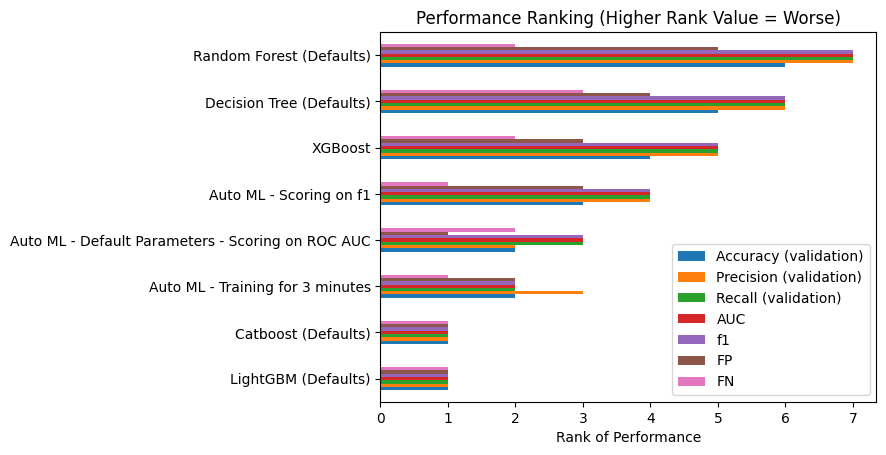

In [141]:
ranking_df.drop(columns="Rank Sum").plot(
    kind="barh",
    title="Performance Ranking (Higher Rank Value = Worse)",
    xlabel="Rank of Performance"
    )